Try training on GHZ state using data in random bases

In [156]:
import numpy as np
import torch

In [157]:
from models import MPS, ComplexTensor

In [158]:
L=2
local_dim=2
bond_dim=2

In [159]:
psi = MPS(L=L, local_dim=local_dim, bond_dim=bond_dim)

Samples_tr: lists indices of the observed basis states at each measurement.

settings: array of corresponding angles

In [160]:
fname_settings = "test_datasets/settings_ghz_plus_random_basis_L=%d.npy"%L
fname_samples = "test_datasets/samples_ghz_plus_random_basis_L=%d.npy"%L
samples = np.load(fname_samples)
samples_tr = torch.tensor((1-samples)/2).to(torch.long)
settings = np.load(fname_settings)

In [161]:
theta = torch.tensor(settings[...,0],dtype=torch.float32)
phi = torch.tensor(settings[...,1],dtype=torch.float32)

In [162]:
from qtools import pauli_exp

In [163]:
U = pauli_exp(theta, phi)
rotations_real = U.real
rotations_imag = U.imag

In [164]:
from torch.utils.data import TensorDataset, DataLoader

In [165]:
from models import MeasurementDataset, ComplexTensor

In [166]:
ds = MeasurementDataset(samples=samples_tr,rotations=U)

In [167]:
batch_size = 10000
lr = 1e-1

In [168]:
dl = DataLoader(ds, batch_size=batch_size, shuffle=True)

In [169]:
losses = []

Number of epochs of training

In [170]:
eps = 20

In [171]:
nstep=1

In [172]:
max_sv = None
cutoff=1e-8

In [173]:
amp1 = []
amp2 = []

In [174]:
s2_schedule = np.concatenate([np.linspace(.0, 0, (eps-1) * len(dl)), np.zeros(len(dl))])

In [175]:
for ep in range(eps):
    for step, inputs in enumerate(dl):
        #get torch tensors representing measurement outcomes, and corresponding local unitaries
        spinconfig = inputs['samples']
        rot = inputs['rotations']
        rotations = ComplexTensor(rot['real'], rot['imag'])
        
        s2_penalty = s2_schedule[ep*len(dl) + step]
        #forward sweep across the chain
        for i in range(L-1):
            for __ in range(nstep):
                psi.do_sgd_step(i, spinconfig,
                                        rotation=rotations,cutoff=cutoff,normalize='left',max_sv_to_keep=max_sv, 
                                       learning_rate=lr, s2_penalty=s2_penalty)   
        for i in range(L-2, -1,-1):
            for __ in range(nstep):
                psi.do_sgd_step(i, spinconfig,
                                        rotation=rotations,cutoff=cutoff,normalize='right',max_sv_to_keep=max_sv, 
                                       learning_rate=lr, s2_penalty=s2_penalty)   
        with torch.no_grad():
            losses.append(psi.nll_loss(spinconfig,rotation=rotations))
            
        #check the relative phase between the two relevant basis states
        s1 = torch.tensor([1,0]* (L//2),dtype=torch.long)
        s2 = torch.tensor([0,1] * (L//2),dtype=torch.long)
        a1 = psi.amplitude_normalized(s1).numpy().item()
        a2 = psi.amplitude_normalized(s2).numpy().item()
        amp1.append(a1)
        amp2.append(a2)
        
        
    print("finished epoch %d" % ep)

        

finished epoch 0
finished epoch 1
finished epoch 2
finished epoch 3
finished epoch 4
finished epoch 5
finished epoch 6
finished epoch 7
finished epoch 8
finished epoch 9
finished epoch 10
finished epoch 11
finished epoch 12
finished epoch 13
finished epoch 14
finished epoch 15
finished epoch 16
finished epoch 17
finished epoch 18
finished epoch 19


In [176]:
import matplotlib.pyplot as plt

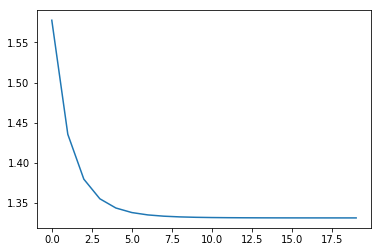

In [177]:
%matplotlib inline
plt.plot(losses)

In [178]:
amp1 = np.asarray(amp1)
amp2 = np.asarray(amp2)
phi1 = np.angle(amp1,deg=True)
phi2 = np.angle(amp2,deg=True)
dphi = phi1-phi2

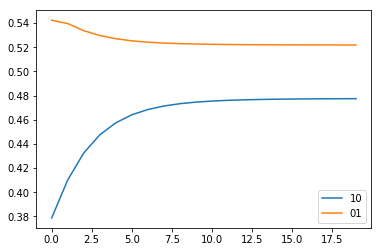

In [179]:
fig, ax = plt.subplots()
plt.plot(np.abs(amp1)**2, label="10")
plt.plot(np.abs(amp2)**2, label="01")
plt.legend()

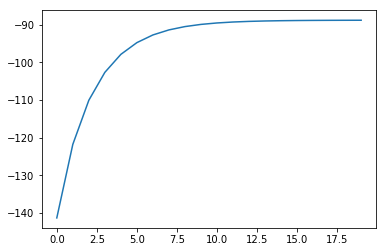

In [180]:
fig, ax = plt.subplots()
plt.plot(dphi)

In [181]:
from tools import generate_binary_space

In [182]:
basis = torch.tensor(generate_binary_space(L),dtype=torch.long)

In [183]:
with torch.no_grad():
    for i in range(len(basis)):
        print("{0} has probability {1:.4f}".format(basis[i], psi.prob_normalized(basis[i]).item()))

tensor([1, 1]) has probability 0.0005
tensor([1, 0]) has probability 0.4775
tensor([0, 1]) has probability 0.5219
tensor([0, 0]) has probability 0.0001


In [184]:
with torch.no_grad():
    for i in range(len(basis)):
        a = psi.amplitude_normalized(basis[i])
        print("{0} has amplitude {1:.4f} + i{2:.4f}".format(basis[i], a.real.item(), a.imag.item()))

tensor([1, 1]) has amplitude -0.0095 + i0.0205
tensor([1, 0]) has amplitude 0.3606 + i0.5895
tensor([0, 1]) has amplitude -0.6086 + i0.3893
tensor([0, 0]) has amplitude -0.0026 + i-0.0087
